In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from sda.encoder_image import Encoder
from sda.img_generator import Generator
from sda.rnn_audio import RNN
from sda.encoder_audio import Encoder as AEncoder

from scipy import signal
from skimage import transform as tf
import numpy as np
from PIL import Image
import contextlib
import shutil
import skvideo.io as sio
import scipy.io.wavfile as wav
import ffmpeg
import face_alignment
from pydub import AudioSegment
from pydub.utils import mediainfo

import glob

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

dev = torch.device("cuda:0")

Random Seed:  999


In [2]:
audio_filenames = glob.glob('/home/jarrod/dev/speech-driven-animation/data/*/*.wav')

# Network

In [3]:
class getDataSample():
    def __init__(self, model_path="grid", gpu=-1):

        if model_path == "grid":
            model_path = "/home/jarrod/dev/speech-driven-animation/sda/data/grid.dat"
#         elif model_path == "timit":
#             model_path = os.path.split(__file__)[0] + "/data/timit.dat"
#         elif model_path == "crema":
#             model_path = os.path.split(__file__)[0] + "/data/crema.dat"

        if gpu < 0:
            self.device = torch.device("cpu")
            model_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
            self.fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device="cpu", flip_input=False)
        else:
            self.device = torch.device("cuda:" + str(gpu))
            model_dict = torch.load(model_path, map_location=lambda storage, loc: storage.cuda(gpu))
            self.fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device="cuda:" + str(gpu),
                                                   flip_input=False)

        self.stablePntsIDs = [33, 36, 39, 42, 45]
        self.mean_face = model_dict["mean_face"]
        self.img_size = model_dict["img_size"]
        self.audio_rate = model_dict["audio_rate"]
        self.video_rate = model_dict["video_rate"]
        self.audio_feat_len = model_dict['audio_feat_len']
        self.audio_feat_samples = model_dict['audio_feat_samples']
        self.id_enc_dim = model_dict['id_enc_dim']
        self.rnn_gen_dim = model_dict['rnn_gen_dim']
        self.aud_enc_dim = model_dict['aud_enc_dim']
        # I think this is the size of the noise vector
        self.aux_latent = model_dict['aux_latent']
        # sequential noise is a boolean value
        self.sequential_noise = model_dict['sequential_noise']
        self.conversion_dict = {'s16': np.int16, 's32': np.int32}
        
        # image preprocessing
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def preprocess_img(self, img):
        src = self.fa.get_landmarks(img)[0][self.stablePntsIDs, :]
        dst = self.mean_face[self.stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src, dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=self.img_size)  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

        return warped

    def _cut_sequence_(self, seq, cutting_stride, pad_samples):
        pad_left = torch.zeros(pad_samples // 2, 1)
        pad_right = torch.zeros(pad_samples - pad_samples // 2, 1)

        seq = torch.cat((pad_left, seq), 0)
        seq = torch.cat((seq, pad_right), 0)

        stacked = seq.narrow(0, 0, self.audio_feat_samples).unsqueeze(0)
        iterations = (seq.size()[0] - self.audio_feat_samples) // cutting_stride + 1
        for i in range(1, iterations):
            stacked = torch.cat((stacked, seq.narrow(0, i * cutting_stride, self.audio_feat_samples).unsqueeze(0)))
        return stacked#.to(self.device)

    def __call__(self, img, audio_path, fs=None, aligned=False):
#         if isinstance(img, str):  # if we have a path then grab the image
#             frm = Image.open(img)
#             frm.thumbnail((400, 400))
#             frame = np.array(frm)
#         else:
#             frame = img

            
        # handle aligning the face with the model's learned "mean face"
        # may also do some preprocessing
#         if not aligned:
#             frame = self.preprocess_img(frame)

        # if we have a path then grab the audio clip
        if isinstance(audio_path, str):  
            info = mediainfo(audio_path)
            fs = int(info['sample_rate'])
            audio = np.array(AudioSegment.from_file(audio_path, info['format_name']).set_channels(1).get_array_of_samples())
            
            if info['sample_fmt'] in self.conversion_dict:
                audio = audio.astype(self.conversion_dict[info['sample_fmt']])
            else:
                if max(audio) > np.iinfo(np.int16).max:
                    audio = audio.astype(np.int32)
                else:
                    audio = audio.astype(np.int16)
        
            
        if fs is None:
            raise AttributeError("Audio provided without specifying the rate. Specify rate or use audio file!")

        if audio.ndim > 1 and audio.shape[1] > 1:
            audio = audio[:, 0]

        max_value = np.iinfo(audio.dtype).max
        
        if fs != self.audio_rate:
            seq_length = audio.shape[0]
            speech = torch.from_numpy(
                signal.resample(audio, int(seq_length * self.audio_rate / float(fs))) / float(max_value)).float()
            speech = speech.view(-1, 1)
            
        else:
            audio = torch.from_numpy(audio / float(max_value)).float()
            speech = audio.view(-1, 1)
            
        
        # take the input image and preprocess it    
#         frame = self.img_transform(frame)#.to(self.device)

        cutting_stride = int(self.audio_rate / float(self.video_rate))
        audio_seq_padding = self.audio_feat_samples - cutting_stride

        # Create new sequences of the audio windows
        audio_feat_seq = self._cut_sequence_(speech, cutting_stride, audio_seq_padding)
#         frame = frame.unsqueeze(0)
        audio_feat_seq = audio_feat_seq.unsqueeze(0)
        audio_feat_seq_length = audio_feat_seq.size()[1]
        
        out = audio_feat_seq.numpy()
        np.save('./data/npy_audio/' + audio_path.split('/')[-1] + '.npy', out)
    
        return #speech, audio_feat_seq, audio_feat_seq_length, frame

# Preprocess Audio Data

In [6]:
va = getDataSample(gpu=0, model_path="grid")

In [13]:
print(len(audio_filenames))
count = 0

for f in audio_filenames:
    if count % 10 == 0:
        print(count)
    va("example/male_face2.jpg", f, aligned=True)
    count += 1

3000
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2

# Preprocess Video Data

In [4]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device="cuda:" + str(0), flip_input=False)
mean_face = np.load('./data/mean_face.npy')

In [5]:
def preprocess_img(img):
    stablePntsIDs = [33, 36, 39, 42, 45]
    
    src = fa.get_landmarks(img)
    if src != None:
        dst = mean_face[stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src[0][stablePntsIDs, :], dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=(128,96))  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

    else:
        warped = np.zeros((128,96,3))
        
    
    
    return warped

def cropFace(frame):
    
    src = fa.get_landmarks(frame)
    err = 0
    
    if src != None and src[0].shape[0] == 68 and src[0].shape[1] == 2:
    
        max_x = int(np.max(src[0][:,0]))
        min_x = int(np.min(src[0][:,0]))

        max_y = int(np.max(src[0][:,1]))
        min_y = int(np.min(src[0][:,1]))

        center_x = int(min_x + (max_x - min_x)/2)
        center_y = int(min_y + (max_y - min_y)/2)

        img_height = 128
        img_width = 96

        left_crop = int(center_x - img_width/2)
        right_crop = int(center_x + img_width/2)

        top_crop = int(center_y - img_height/2)
        bottom_crop = int(center_y + img_height/2)

        crop = frame[top_crop:bottom_crop, left_crop:right_crop, :]
        
#         print("crop ", crop.shape)
    
    else:
        err = 1
        crop = 0
    
    return crop, err

def alignFace(vid_data, fname):
    
    new_vid = []
    
    for i, frame in enumerate(vid_data):
          
        crop, err = cropFace(frame)
        
#         print("err", err)
#         if err != 1:
#             print("2nd crop ", crop.shape)
        
        if err == 0:
#             print("immediately before", crop.shape)
            new_vid.append(preprocess_img(crop))
        else:
            print("error in ", fname, " at frame ", i)
    
    err = 0
    
    if len(new_vid) < 1:
        err = 1
        out = None
    else:
        out = np.stack(new_vid)
    
    return out, err

In [ ]:
count = 0

# for f in audio_filenames:
    
    
for f in range(2600,3000):
    
    f = audio_filenames[f]
    print("file: ", f)
    if count % 10 == 0:
        print(count, " of " + str(len(audio_filenames)))
    vid_data = sio.vread(f.split('.wav')[0] + ".mpg")
    out, err = alignFace(vid_data, f.split('.wav')[0] + ".mpg")
    
    if err != 1:
        np.save('./data/aligned_faces/' + f.split('/')[-1].split('.wav')[0] + ".npy", out)
    else:
        print("error with video ", vid_data, f.split('.wav')[0] + ".mpg")
    count += 1

file:  /home/jarrod/dev/speech-driven-animation/data/s1/pbbv9a.wav
0  of 3000
file:  /home/jarrod/dev/speech-driven-animation/data/s1/sbat9a.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/lrwr9s.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/lrwl5s.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/bwbn5a.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/lbwl1a.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/bgan7a.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/bgwo3s.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/sbbuzn.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/sbbh2n.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/pbac2p.wav
10  of 3000
file:  /home/jarrod/dev/speech-driven-animation/data/s1/srau2n.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/pbbp4p.wav
file:  /home/jarrod/dev/speech-driven-animation/data/s1/bgbh6p.wav
file:  /home/jarrod/dev/speech-driven-a

# Clean Data

In [4]:
audio_filenames_proc = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

In [35]:
bad_files = [601, 1454, 1743, 2799]

In [34]:
for i, f in enumerate(audio_filenames_proc):
    
    file = np.load(f)
    
    for frame in file:
        
        if frame.dtype != 'uint8':
            print("bad file ", f, "#: ", i)
        
#         if np.sum(frame) == 0:
#             print("No data in frame in file: ", f, "#: ", i)

bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy #:  601
bad file  /home/jarro

bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  /home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy #:  1743
bad file  

In [9]:
vid = np.load('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/lrbr3s.npy')

In [40]:
vid = np.load(audio_filenames_proc[1500])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


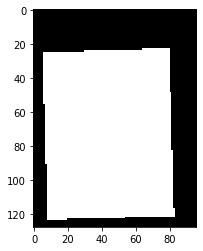

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


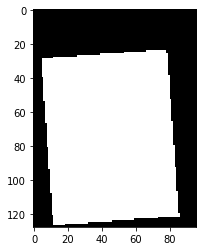

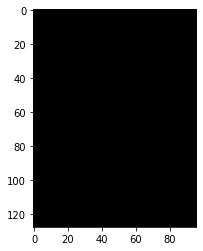

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


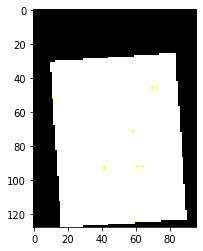

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


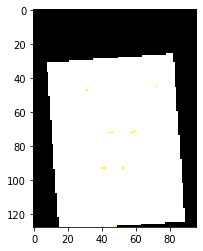

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


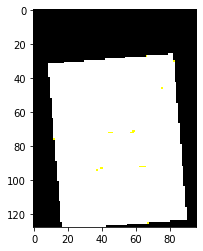

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


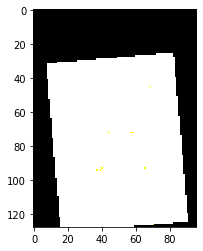

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


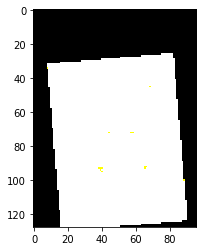

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


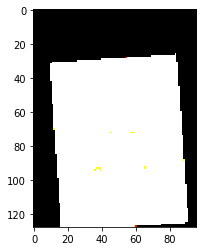

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


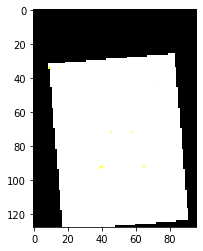

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


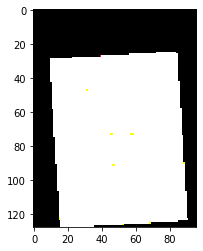

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


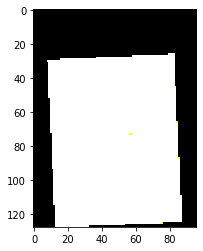

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


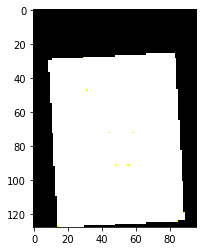

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


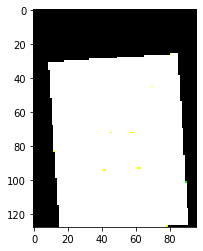

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


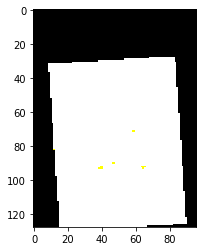

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


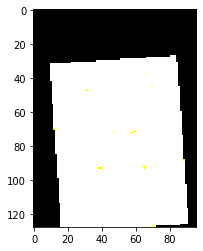

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


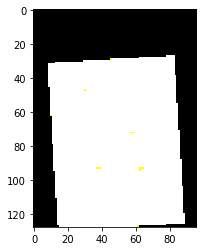

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


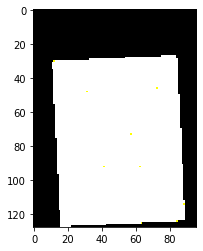

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


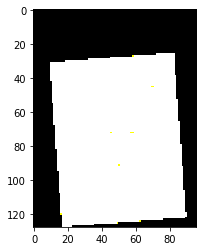

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


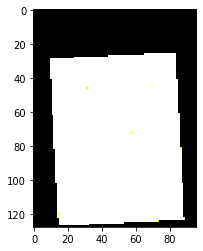

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


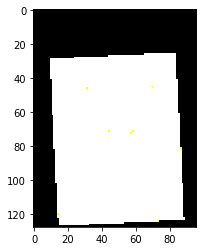

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


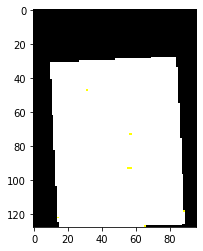

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


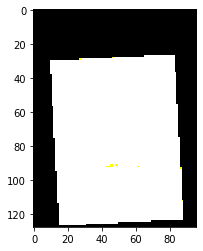

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


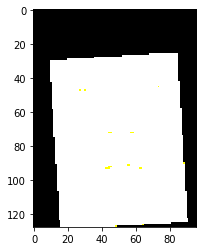

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


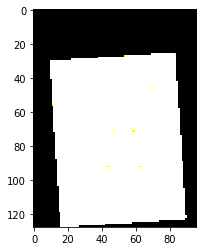

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


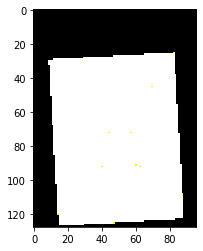

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


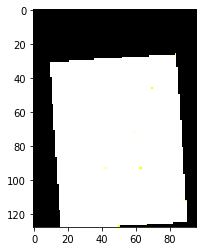

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


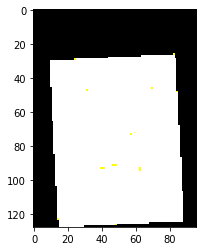

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


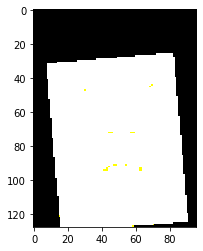

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


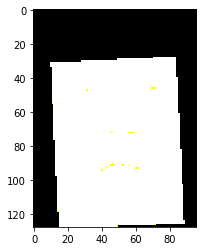

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


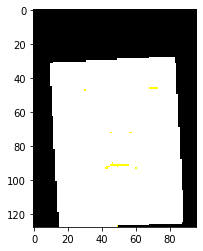

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


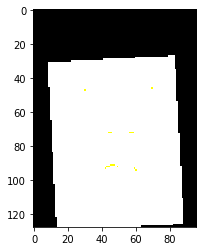

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


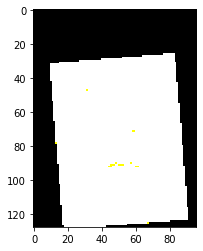

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


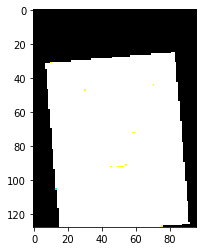

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


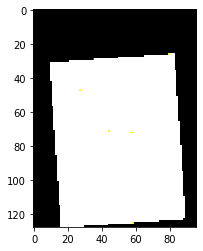

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


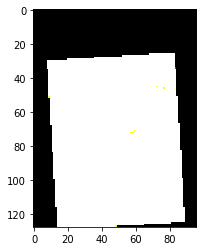

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


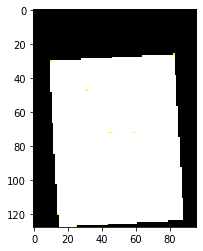

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


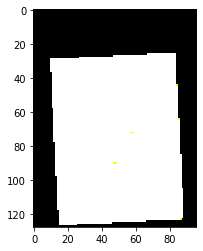

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


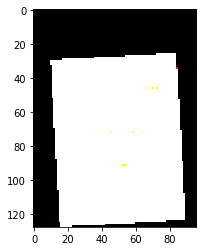

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


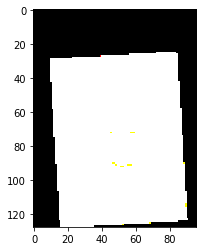

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


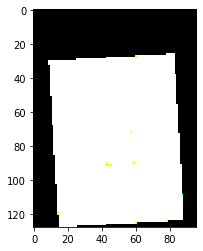

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


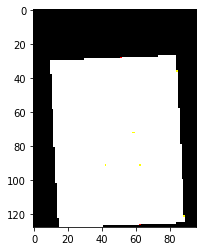

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


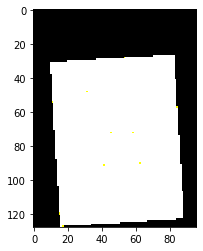

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


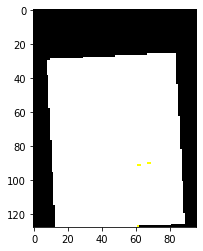

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


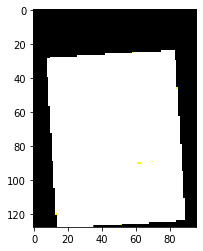

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


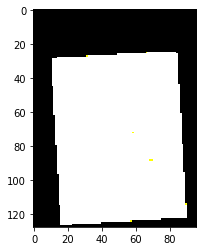

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


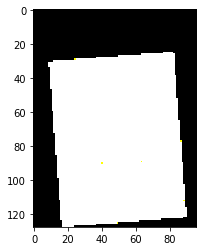

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


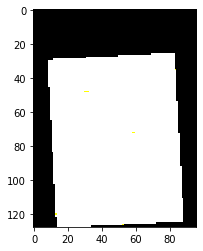

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


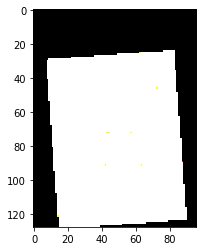

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


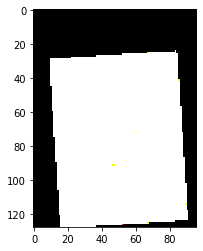

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


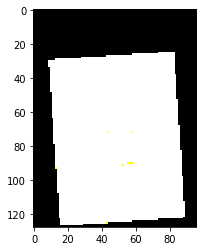

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


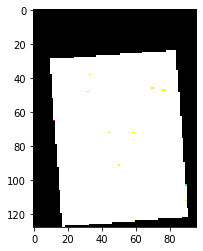

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


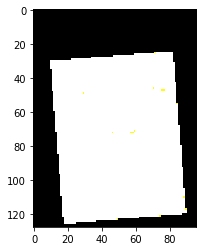

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


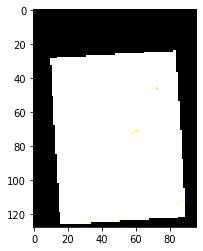

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


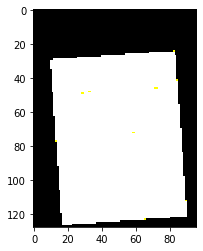

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


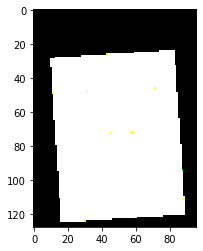

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


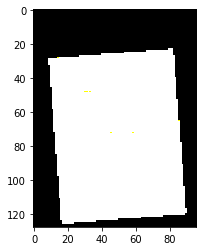

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


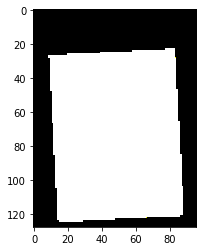

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


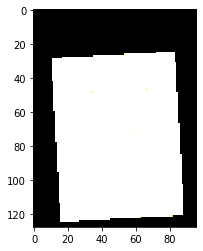

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


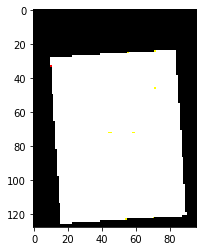

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


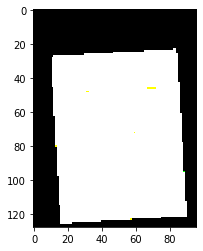

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


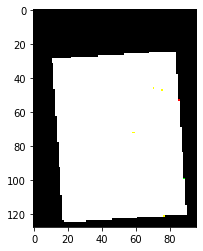

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


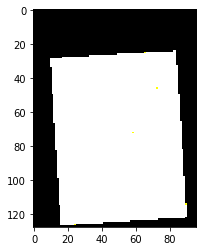

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


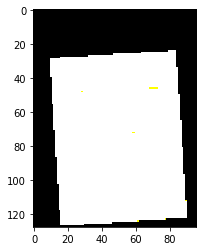

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


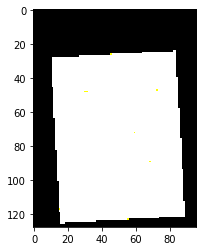

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


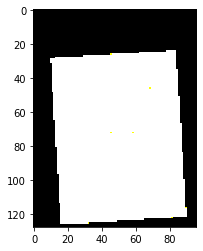

In [10]:
for frame in vid:

    plt.imshow(frame)
    plt.show()

In [43]:
audio_filenames_proc[600:603]

['/home/jarrod/dev/speech-driven-animation/data/aligned_faces/briz9a.npy',
 '/home/jarrod/dev/speech-driven-animation/data/aligned_faces/bgit2n.npy',
 '/home/jarrod/dev/speech-driven-animation/data/aligned_faces/srbh9p.npy']

In [44]:
del audio_filenames_proc[601]

In [45]:
audio_filenames_proc[600:603]

['/home/jarrod/dev/speech-driven-animation/data/aligned_faces/briz9a.npy',
 '/home/jarrod/dev/speech-driven-animation/data/aligned_faces/srbh9p.npy',
 '/home/jarrod/dev/speech-driven-animation/data/aligned_faces/srwi5a.npy']